In [ ]:
%load_ext autoreload
%autoreload 2
from lib.ekyn import *
from sklearn.model_selection import train_test_split
from torch import bincount
from lib.utils import plot_eeg_and_labels
from lib.models import MLP
from tqdm import tqdm
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import numpy as np
import random
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from lib.env import DEVICE
from lib.utils import Windowset
from torch.nn.functional import relu
import json
from lib.ekyn import *
from lib.models import RegNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

PROJECT_DIR = f'projects/11'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)
model = RegNet(in_features=CONFIG['WINDOW_SIZE'],in_channels=1,depthi=CONFIG['DEPTHI'],widthi=CONFIG['WIDTHI'])
criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716]))
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))

In [ ]:
from lib.datasets import EpochedDataset
from torch.utils.data import ConcatDataset
from lib.ekyn import get_ekyn_ids
train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
# trainloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)
devloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)
model = RegNet(in_features=CONFIG['WINDOW_SIZE'],in_channels=1,depthi=CONFIG['DEPTHI'],widthi=CONFIG['WIDTHI'])
criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716]))
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))

In [ ]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

In [ ]:
model.to('cpu')
Xi,yi = next(iter(devloader))

fig,ax = plt.subplots(nrows=len(model.c1.weight),ncols=2,figsize=(8,10))
for i,kernel in enumerate(model.c1.weight.squeeze().detach()):
    ax[i,0].plot(kernel)
for i,kernel in enumerate(model.c1(Xi.reshape(-1,1,5000)).detach()[0]):
    ax[i,1].plot(kernel)

In [ ]:
from torch.utils.data import TensorDataset
id = test_idx[3]
print(id)
X,y = load_ekyn_pt_standardized(idx=id,condition='Vehicle')
print(X.shape,y.shape)
print(bincount(y.argmax(axis=1)))
testloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=False)
import matplotlib.pyplot as plt
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

In [28]:
from sklearn.metrics import f1_score

criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716]))

PROJECT_DIR = f'projects/2'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)
modela = RegNet(in_features=CONFIG['WINDOW_SIZE'],in_channels=1,depthi=CONFIG['DEPTHI'],widthi=CONFIG['WIDTHI'])
modela.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))

PROJECT_DIR = f'projects/11'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)
modelb = RegNet(in_features=CONFIG['WINDOW_SIZE'],in_channels=1,depthi=CONFIG['DEPTHI'],widthi=CONFIG['WIDTHI'])
modelb.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))

f1s_a = []
f1s_b = []

for id in test_idx:
    for condition in ['Vehicle','PF']:
        X,y = load_ekyn_pt(idx=id,condition=condition)
        testloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=False)
        loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=DEVICE)
        f1s_a.append(f1_score(y_true,y_pred,average='macro'))

for id in test_idx:
    for condition in ['Vehicle','PF']:
        X,y = load_ekyn_pt_standardized(idx=id,condition=condition)
        testloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=False)
        loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=modelb,criterion=criterion,DEVICE=DEVICE)
        f1s_b.append(f1_score(y_true,y_pred,average='macro'))

100%|██████████| 17/17 [00:00<00:00, 50.00it/s]
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 17/17 [00:00<00:00, 50.42it/s]
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 17/17 [00:00<00:00, 49.42it/s]
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

<Axes: ylabel='Proportion'>

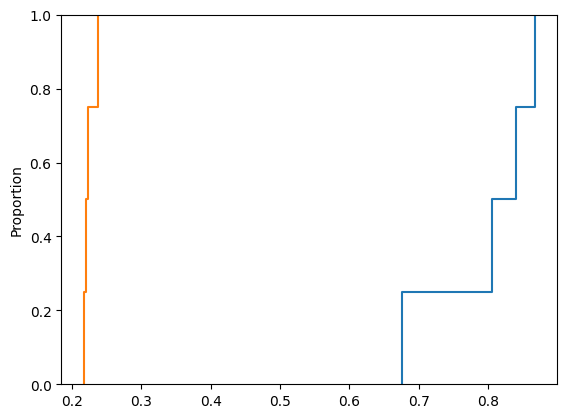

In [29]:
import seaborn as sns
sns.ecdfplot(f1s)
sns.ecdfplot(f1s_b)

In [ ]:
import matplotlib.patches as patches
start = 0
duration = 1000

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(16,10),dpi=100,sharex=True)

colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[3].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

y_logits_tmp = torch.tensor([[val]*CONFIG['WINDOW_SIZE'] for val in list(y_logits[start:start+duration].numpy())]).flatten(0,1)

ax[0].stackplot(range(len(y_logits_tmp)),y_logits_tmp[:,0],y_logits_tmp[:,1],y_logits_tmp[:,2],colors=['#FF000080','#00FF0080','#0000FF80'])

ax[1].plot(torch.cat([torch.tensor([[val]*CONFIG['WINDOW_SIZE'] for val in list(y_pred[start:start+duration].numpy())]).flatten()]))
ax[1].set_yticks([0,1,2],['Paradoxical','Slow-Wave','Wakefulness'])
ax[1].margins(0,0)
ax[1].set_ylim([-.1,2.1])
ax[1].set_title('predicted activity')

ax[2].plot(torch.cat([torch.tensor([[val]*CONFIG['WINDOW_SIZE'] for val in list(y_true[start:start+duration].numpy())]).flatten()]))
ax[2].set_yticks([0,1,2],['Paradoxical','Slow-Wave','Wakefulness'])
ax[2].margins(0,0)
ax[2].set_ylim([-.1,2.1])
ax[2].set_title('reference activity')

ax[3].plot(X[start:start+duration].flatten(),'black',linewidth=.3)
ax[3].margins(0,0)
ax[3].set_ylim([-.0003,.0003])
ax[3].set_ylabel('potential energy (Volts)')
ax[3].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);
ax[3].set_title('expert labeling')

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')

plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left',bbox_to_anchor=(1.04, 1),fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (each being 10 seconds)')
plt.savefig('Sleep3.jpg',bbox_inches='tight')